<a href="https://colab.research.google.com/github/Pedro-Boechat/trainee/blob/main/Periodo5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import time
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin
from sklearn.model_selection import train_test_split
import random

In [3]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

In [6]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

dataset_path = '/content/gdrive/MyDrive/animals'

Mounted at /content/gdrive


In [7]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [8]:
train_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(256, 256), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='training', interpolation='nearest'
)

valid_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(256, 256), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=True, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='validation', interpolation='nearest'
)

test_generator = train_datagen.flow_from_directory(
    dataset_path, target_size=(256, 256), color_mode='rgb', classes=['cats', 'dogs', 'panda'],
    class_mode='categorical', batch_size=32, shuffle=False, seed=None,
    save_to_dir=None, save_prefix='', save_format='jpg',
    follow_links=False, subset='validation', interpolation='nearest'
)

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


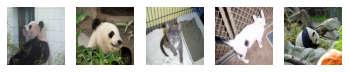

[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [46]:
imgs, labels = train_generator[0]

def plotImages(imgs):
  fig, axes = plt.subplots(1,5)
  axes = axes.flatten()
  for img, ax in zip(imgs, axes):
    ax.imshow(img)
    ax.axis('off')

  plt.show()

plotImages(imgs)
print(labels[:5])

In [18]:
model = tf.keras.Sequential([
                             tf.keras.layers.Conv2D(32,(5,5), activation = 'relu', input_shape = (256, 256, 3)),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Conv2D(32,(5,5), activation = 'relu'),
                             tf.keras.layers.MaxPooling2D(2,2),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(32, activation = tf.nn.relu),
])
model.add(tf.keras.layers.Dense(3, activation = tf.nn.softmax))

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 252, 252, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 122, 122, 32)      25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 119072)            0         
                                                                 
 dense_3 (Dense)             (None, 32)               

In [20]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
model.fit(
    train_generator,
    epochs = 3,
    steps_per_epoch = train_generator.samples // 32,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 32)

Epoch 1/3


InvalidArgumentError: ignored

In [14]:
len(train_generator)

75

In [10]:
75 * 2

150

In [37]:
history = model.fit(train_generator, labels, batch_size = 128, epochs = 5)

ValueError: ignored

In [28]:
def cnn_model_fn(features, labels, mode):
  """Model function for CNN."""
  # Input Layer
  input_layer = tf.reshape(features["x"], [-1, 256, 256, 3])

  # Convolutional Layer
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

  # Pooling Layer
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

  # Convolutional Layer #2 and Pooling Layer
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=36,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

  # Dense Layer
  pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 36])
  dense = tf.layers.dense(inputs=pool2_flat, units=7 * 7 * 36, activation=tf.nn.relu)
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

  # Logits Layer
  logits = tf.layers.dense(inputs=dropout, units=10)

  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }

  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

  # Calculate Loss
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

  # Configure the Training Op (for TRAIN mode)
  if mode == tf.estimator.ModeKeys.TRAIN:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(
        loss=loss,
        global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

  # Add evaluation metrics Evaluation mode
  eval_metric_ops = {
      "accuracy": tf.metrics.accuracy(
          labels=labels, predictions=predictions["classes"])}
  return tf.estimator.EstimatorSpec(
      mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [29]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="train/mnist_convnet_model")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'train/mnist_convnet_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [30]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)

AttributeError: ignored

In [31]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": X_train_scaled},
    y=y_train,
    batch_size=100,
    num_epochs=None,
    shuffle=True)
mnist_classifier.train(
    input_fn=train_input_fn,
    steps=16000,
    hooks=[logging_hook])

AttributeError: ignored